## **Modelo CNN Simple - ResNet18 + Dropout + Soft Attention Espacial** 

In [1]:
import io
import torch
import os
import subprocess
import logging
import pandas as pd
import seaborn as sns
import torch.optim as optim
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from datetime import datetime
from torchvision import transforms
from torch.utils.data import Subset
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from torchsummary import summary
from PIL import Image
from tensorboard.backend.event_processing import event_accumulator
from sklearn.utils import resample
from sklearn.metrics import classification_report
from collections import Counter
%matplotlib inline

## Definición de transformación de los datos de entrada

In [2]:
class MinMaxNormalize(object):
    """Transformación para normalizar imágenes con Min-Max a rango [0, 1]."""
    def __call__(self, image):
        image = transforms.ToTensor()(image)  # Convertir a tensor primero
        # Normalización Min-Max: (pixel - min) / (max - min)
        return (image - image.min()) / (image.max() - image.min() + 1e-7)
    
normal_train_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Redimensionar después de las transformaciones
    MinMaxNormalize(),
    
])

augmented_train_transform = transforms.Compose([
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),  # Recorte aleatorio con zoom entre 80%-100%
    transforms.RandomHorizontalFlip(p=0.5),  # Voltea horizontalmente con 50% de probabilidad
    transforms.RandomRotation(15),  # Rotación aleatoria hasta 15 grados
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Ajuste aleatorio de color
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Pequeños desplazamientos aleatorios
    transforms.Resize((128, 128)),  # Redimensionar después de las transformaciones
    MinMaxNormalize(),
    
    
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Solo redimensionar en validación (sin data augmentation)
    MinMaxNormalize(),
    
    
])


## Definición del dataset

In [3]:
class CustomDataset(Dataset):
    def __init__(self, df, img_dir, class_to_idx, normal_transform=None, augmented_transform = None, val_transform = None):
        """
        Args:
            df: Dataset con la data de cada archivo
            img_dir (str): Ruta al directorio que contiene las imágenes.
            transform (callable, optional): Transformaciones que se aplican a las imágenes.
        """
        self.img_labels = df
        self.img_dir = img_dir  # Ruta donde están las imágenes
        self.class_to_idx = class_to_idx
        self.normal_transform = normal_transform
        self.augmented_transform = augmented_transform
        self.val_transform = val_transform
        

    def __len__(self):
        """Retorna el número total de imágenes en el dataset"""
        return len(self.img_labels)

    def __getitem__(self, idx):
        # Obtenemos la fila correspondiente
        row = self.img_labels.iloc[idx]
        # Suponiendo que la columna 0 contiene el nombre del archivo
        img_name = os.path.join(self.img_dir, row.iloc[0])
        image = Image.open(img_name).convert("RGB")
        label = self.class_to_idx[row['diagnosis']]
        
        # Transformacion de la data de validacion
        if self.val_transform:
            image = self.val_transform(image)
        elif self.normal_transform != None or self.augmented_transform != None:
            # Transformacion de la data de prueba
            # Verificamos la columna 'oversampled'
            if row['oversampled']:
                # Si es oversampled, aplicamos la transformación de data augmentation
                if self.augmented_transform:
                    image = self.augmented_transform(image)
            else:
                # Si es un registro original, aplicamos la transformación normal
                if self.normal_transform:
                    image = self.normal_transform(image)
        
        return image, label

## Rutas de archivos

In [4]:
desdeGoogleColab = False
drive_mount_path = ""
try:
    from google.colab import drive
    desdeGoogleColab = True
    drive_mount_path = os.path.join('content','drive')
    drive.mount(drive_mount_path)
    print("Ejecutando desde Google Colab")
    
except:
    print("Ejecutando desde notebook")

initialRoute = os.path.join(drive_mount_path, 'MyDrive')if desdeGoogleColab else os.path.join('content')


# Leer el CSV
csvRoute = os.path.join(initialRoute,'GPTeam-DeepLearning','Dataset', 'bcn_20k_train.csv')
filteredCsvRoute = os.path.join(initialRoute,'GPTeam-DeepLearning','Dataset', 'bcn_20k_train_filtrado.csv')
imagesFolderRoute = os.path.join(initialRoute,'GPTeam-DeepLearning','Dataset', 'bcn_20k_train')
trainDataJsonRoute = os.path.join(initialRoute,'GPTeam-DeepLearning','Dataset', 'data_train_resnet18_softAtt.json')
validationDataJsonRoute = os.path.join(initialRoute,'GPTeam-DeepLearning','Dataset', 'data_val_resnet18_softAtt.json')
runsRoute = os.path.join(initialRoute,'GPTeam-DeepLearning','Dataset', 'runs') if desdeGoogleColab else os.path.join('runs')
savedParametersRoute = os.path.join(initialRoute,'GPTeam-DeepLearning','Dataset', 'saved_models_parameters', 'Parameters') if desdeGoogleColab else os.path.join('saved_models_parameters', 'Parameters')
savedModelsRoute = os.path.join(initialRoute,'GPTeam-DeepLearning','Dataset', 'saved_models_parameters', 'Models') if desdeGoogleColab else os.path.join('saved_models_parameters', 'Models')
executionLogerRoute = os.path.join(initialRoute, 'executionLogs.txt') if desdeGoogleColab else os.path.join("executionLogs.txt")

Ejecutando desde notebook


Configuración del logger

In [38]:
# Configurar el logger
logging.basicConfig(
    filename=executionLogerRoute,  # Nombre del archivo de logs
    level=logging.INFO,      # Nivel mínimo de los logs (INFO es un nivel común)
    format='%(asctime)s - %(message)s',  # Formato del log (con la fecha y hora)
)

## Generación del dataset de entrenamiento y validación

***Carga del dataframe***

In [6]:
df = pd.read_csv(csvRoute)
df.head()

,bcn_filename,age_approx,anatom_site_general,diagnosis,lesion_id,capture_date,sex,split
0,BCN_0000000001.jpg,55.0,anterior torso,MEL,BCN_0003884,2012-05-16,male,train
1,BCN_0000000003.jpg,50.0,anterior torso,MEL,BCN_0000019,2015-07-09,female,train
2,BCN_0000000004.jpg,85.0,head/neck,SCC,BCN_0003499,2015-11-23,male,train
3,BCN_0000000006.jpg,60.0,anterior torso,NV,BCN_0003316,2015-06-16,male,train
4,BCN_0000000010.jpg,30.0,anterior torso,BCC,BCN_0004874,2014-02-18,female,train


***Exclusión de clases menos representativas***

In [7]:
df_original = df.copy()
#Definir las clases que deseas excluir por su nombre
clases_a_excluir = ['SCC', 'DF', 'VASC']  # Sustituye estos nombres por las clases que quieres excluir

# Filtrar el DataFrame para excluir las clases especificadas
df_filtrado = df[~df['diagnosis'].isin(clases_a_excluir)]

df_filtrado.to_csv(filteredCsvRoute, index=False)

df = df_filtrado.copy()
class_to_idx = {class_name: idx for idx, class_name in enumerate(df['diagnosis'].unique())}
class_to_idx

{'MEL': 0, 'NV': 1, 'BCC': 2, 'BKL': 3, 'AK': 4}

***Busqueda de spliteo adecuado (sin lesson_id iguales para dataset de entrenamiento y validación)***

In [8]:
# Obtener los valores únicos de lesion_id
unique_lesions = df['lesion_id'].unique()

# Búsqueda del mejor split
best_train, best_test = None, None
target_ratio = 0.8 * len(df)

for seed in range(1000):  # Exploramos diferentes random_state
    train_ids, test_ids = train_test_split(unique_lesions, test_size=0.2, random_state=seed)

    x_train = df[df['lesion_id'].isin(train_ids)]
    x_test = df[df['lesion_id'].isin(test_ids)]

    # Verificar que la cantidad de filas sea la correcta Y que los lesion_id no se repitan
    if abs(len(x_train) - target_ratio) < 1 and set(x_train['lesion_id']).isdisjoint(set(x_test['lesion_id'])):
        best_train, best_test = x_train, x_test
        print(f"Random state encontrado: {seed}")
        break

# Si no se encontró un split válido, lanzar error
if best_train is None or best_test is None:
    raise ValueError("No se encontró un split válido después de 1000 intentos")

# Asignar los mejores valores encontrados
train_df, val_df = best_train, best_test

assert set(train_df['lesion_id']).isdisjoint(set(val_df['lesion_id'])), "Error: Hay lesion_id repetidos entre train_df y val_df"

Random state encontrado: 25


In [9]:
# VERIFICACION ADICIONAL DE NO REPETICION DE LESSIONID EN AMBOS DATASETS
for idtrain in train_df['lesion_id'].unique():
    for idval in val_df['lesion_id'].unique():
        if idtrain.strip() == idval.strip():
            print("Coincidence found")

In [10]:
# Verificación de la carga de todos los arhivos
archivos_en_directorio = []
# Recorrer todos los archivos en el directorio
for archivo in os.listdir(imagesFolderRoute):
    if os.path.isfile(os.path.join(imagesFolderRoute, archivo)):
        archivos_en_directorio.append(archivo)

# La columna del DataFrame con los nombres de los archivos
column_files = df['bcn_filename']
# Convertir las listas a conjuntos para realizar la diferencia
set_column_files = set(column_files)
set_archivos_en_drive = set(archivos_en_directorio)
valores_faltantes = set_column_files - set_archivos_en_drive

print(f"Cantidad de imagenes faltantes: {len(valores_faltantes)}")

Cantidad de imagenes faltantes: 0


*Downsampling de la clase más representativa y registro de data augmentation para las clases menos representativas*

In [11]:
train_df['oversampled'] = False
random_downsampling_seed = 42
np.random.seed(seed)
balanced_dfs = []

class_counts = train_df['diagnosis'].value_counts()
target = int(round(class_counts.mean()))
print("Recuento original por clase:")
print(class_counts)
print("Cantidad objetivo (media) por clase:", target)

for diag, count in class_counts.items():
    df_class = train_df[train_df['diagnosis'] == diag]
    if count > target:
        # Downsampling: eliminamos registros de forma aleatoria hasta alcanzar el target
        df_downsampled = df_class.sample(n=target, random_state=seed)
        balanced_dfs.append(df_downsampled)
    elif count < target:
        # Oversampling: duplicamos registros mediante muestreo con reemplazo para alcanzar el target
        num_needed = target - count
        df_oversampled = df_class.sample(n=num_needed, replace=True, random_state=seed).copy()
        df_oversampled['oversampled'] = True
        df_class_balanced = pd.concat([df_class, df_oversampled], ignore_index=True)
        balanced_dfs.append(df_class_balanced)
    else:
        balanced_dfs.append(df_class)

balanced_df = pd.concat(balanced_dfs, ignore_index=True)
print("\nRecuento balanceado por clase en el DataFrame:")
print(balanced_df['diagnosis'].value_counts())
train_df = balanced_df

Recuento original por clase:
diagnosis
NV     3255
MEL    2344
BCC    2281
BKL     924
AK      593
Name: count, dtype: int64
Cantidad objetivo (media) por clase: 1879

Recuento balanceado por clase en el DataFrame:
diagnosis
NV     1879
MEL    1879
BCC    1879
BKL    1879
AK     1879
Name: count, dtype: int64


C:\Users\User\AppData\Local\Temp\ipykernel_18568\2817559854.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['oversampled'] = False


## **Guardado de los datasets divididos inicialmente**

**Guardado de data de dataframes de entrenamiento y validación**

In [12]:
train_df.to_json(trainDataJsonRoute, orient='records', lines=True)
val_df.to_json(validationDataJsonRoute, orient='records', lines=True)

**Definición del Modelo**

In [13]:
# Mecanismo de Soft-Attention Espacial
class SpatialAttention(nn.Module):
    def __init__(self, in_channels):
        super(SpatialAttention, self).__init__()
        self.conv_attention = nn.Sequential(
            nn.Conv2d(in_channels, 1, kernel_size=1),  # Mapa de atención 1x1
            nn.Softmax(dim=2)                           # Normalización espacial
        )
        
    def forward(self, x):
        # x: (batch, 512, H, W) [Ej: (batch, 512, 7, 7)]
        # Generar mapa de atención (batch, 1, H, W)
        attn_weights = self.conv_attention(x)
        # Aplicar atención: características * pesos
        attended_features = x * attn_weights  # Broadcasting automático
        
        return attended_features


# Modelo ResNet18 con Dropout + Soft-Attention
class ResNet18WithAttention(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18WithAttention, self).__init__()
        # 1. Cargar ResNet18 preentrenado
        self.resnet18 = models.resnet18(pretrained=True)
        
        # 2. Congelar capas convolucionales
        for param in self.resnet18.parameters():
            param.requires_grad = False

        # 2.1 Descongelar la ultima capa
        for param in self.resnet18.layer4.parameters():
            param.requires_grad = True

        # 2.1 Descongelar la ultima capa
        for param in self.resnet18.layer3.parameters():
            param.requires_grad = True
        
        # 3. Añadir mecanismo de atención espacial
        self.attention = SpatialAttention(in_channels=512)  # ResNet18 tiene 512 canales al final
        
        # 4. Modificar capas FC con Dropout
        self.resnet18.fc = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # Extraer características hasta la última capa convolucional
        x = self.resnet18.conv1(x)
        x = self.resnet18.bn1(x)
        x = self.resnet18.relu(x)
        x = self.resnet18.maxpool(x)
        x = self.resnet18.layer1(x)
        x = self.resnet18.layer2(x)
        x = self.resnet18.layer3(x)
        x = self.resnet18.layer4(x)  # Salida: (batch, 512, 7, 7)
        
        # Aplicar atención espacial
        x = self.attention(x)  # (batch, 512, 7, 7) con pesos aprendidos
        
        # Global Average Pooling y clasificación
        x = self.resnet18.avgpool(x)  # (batch, 512, 1, 1)
        x = torch.flatten(x, 1)       # (batch, 512)
        x = self.resnet18.fc(x)       # (batch, num_classes)
        
        return x

# Visualización de la ejecución del modelo

Ejecutar desde cmd lo siguiente para ver desde el navegador el menú de tensorboard: tensorboard --logdir=runs

Ejecucion en navegador

In [14]:
def run_tensorboard(logdir="runs", port=6006):
    try:
        process = subprocess.Popen(
            ["tensorboard", f"--logdir={logdir}", f"--port={port}"],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE
        )
        print(f"TensorBoard ejecutándose en http://localhost:{port}")
        return process
    except Exception as e:
        print(f"Error al iniciar TensorBoard: {e}")

# Ejecutar TensorBoard
tb_process = run_tensorboard()

TensorBoard ejecutándose en http://localhost:6006


Ejecucion en notebook

In [15]:
%reload_ext tensorboard
%tensorboard --logdir "$runsRoute"

Reusing TensorBoard on port 6007 (pid 22044), started 7 days, 23:15:13 ago. (Use '!kill 22044' to kill it.)

## **Entrenamiento del modelo**

**Seteo del dispositivo a usar**

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(F"Dispositivo utilizado: {device} ({torch.cuda.get_device_name()})")
else:
    print(F"Dispositivo utilizado: {device}")

Dispositivo utilizado: cuda (NVIDIA GeForce RTX 2060)


**Especificación de parámetros**

In [18]:
learning_rate = 0.0001
num_classes = 5
num_epochs = 5
batch_size = 32

**Ejecución del modelo**

In [ ]:
# Crear el dataset de entrenamiento y validación
train_dataset = CustomDataset(
    df=train_df,
    img_dir=imagesFolderRoute,
    class_to_idx=class_to_idx,
    normal_transform=normal_train_transform,
    augmented_transform=augmented_train_transform)
val_dataset = CustomDataset(
    df=val_df,
    img_dir=imagesFolderRoute,
    class_to_idx=class_to_idx,
    val_transform=val_transform
    )

# Actualizar los datasets con los subconjuntos correspondientes
train_dataset.img_labels = train_df
val_dataset.img_labels = val_df

# Inicialización de tensorboard
executionModelDateTime = datetime.now().strftime("Ejecucion %d-%m-%Y %H-%M")
writer = SummaryWriter(log_dir=runsRoute)

# Crear los DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Definición de la cantidad de clases, la función de perdida, el optimizador y el learning rate estático
modelAt = ResNet18WithAttention(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(modelAt.parameters(), lr=learning_rate, momentum=0.9,weight_decay=1e-3)
optimizer = optim.Adam(modelAt.parameters(), lr=learning_rate, weight_decay=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
model = modelAt.to(device)
executionStatistics_list = []

for epoch in range(num_epochs):
    model.train()  # Modo entrenamiento
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    # Entrenamiento
    for inputs, labels in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=True):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Estadísticas de la pérdida
        running_loss += loss.item()
        # Precisión
        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

    #print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_dataloader)}, Accuracy: {100 * correct_preds / total_preds}%")
    train_loss = running_loss / len(train_dataloader)
    train_accuracy = 100 * correct_preds / total_preds

    # Validación
    model.eval()  # Modo evaluación
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    all_groundtruth = []
    all_predictions = []

    with torch.no_grad():  # No calcular gradientes durante la validación
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()  # Usamos correct_val en lugar de correct_preds
            total_val += labels.size(0)  # Usamos total_val en lugar de total_preds

            all_groundtruth.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    val_loss = running_val_loss/len(val_dataloader)
    val_accuracy = 100 * correct_val / total_val
    
    # Ajustar la tasa de aprendizaje si la pérdida de validación no mejora
    scheduler.step(val_loss)
    
    # Agregar valores a TensorBoard
    writer.add_scalar("Loss/Train", train_loss, epoch)
    writer.add_scalar("Loss/Validation", val_loss, epoch)
    writer.add_scalar("Accuracy/Train", train_accuracy, epoch)
    writer.add_scalar("Accuracy/Validation", val_accuracy, epoch)

    # Obtener los nombres de las clases (suponiendo que están en df_filtrados.columns)
    labels_names = list(df_filtrado['diagnosis'].unique())
    
    # Carga de hiperparametros y metricas
    execution_statistics = {
        "epoch": epoch,
        "batch_size": batch_size,
        "learning_rate": learning_rate,
        "num_epochs": num_epochs,
        "Train Loss": train_loss,
        "Validation Loss": val_loss,
        "Train Accuracy": train_accuracy,
        "Validation Accuracy": val_accuracy
        
    }
    
    executionStatistics_list.append(execution_statistics)
    
    # Gráfica de loss y accuracy por cada epoca
    writer.add_scalars("Loss", {"Train": train_loss, "Validation": val_loss}, epoch)
    writer.add_scalars("Accuracy", {"Train": train_accuracy, "Validation": val_accuracy}, epoch)
    
    
    print(f"Epoch {epoch+1}/{num_epochs} FINISHED => "
        f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
        f"Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%")
    
writer.flush()
writer.close()

# Guardado del modelo completo
torch.save(model, os.path.join(savedModelsRoute, f"{executionModelDateTime}_modelo_entrenado_resnet18_softAtt_ka_completo.pth"))
# Guardado de los pesos del modelo
torch.save(model.state_dict(), os.path.join(savedParametersRoute, f"{executionModelDateTime}_modelo_entrenado_resnet18_softAtt_ka_pesos.pth"))

execution_log_message = f"Ejecucion de {num_epochs} epocas, learning rate: {learning_rate} y batch size: {batch_size}. Archivo de ejecucion guardado en {runsRoute}"
logging.info(execution_log_message)


d:\PUCP\Cursos electivos\Deep Learning\Proyecto General\Proyecto\Deep-Learning---Proyecto\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\PUCP\Cursos electivos\Deep Learning\Proyecto General\Proyecto\Deep-Learning---Proyecto\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/5 - Training: 100%|██████████| 294/294 [04:06<00:00,  1.19it/s]


Epoch 1/5 FINISHED => Train Loss: 0.9585, Val Loss: 0.9992, Train Acc: 62.09%, Val Acc: 59.79%


Epoch 2/5 - Training: 100%|██████████| 294/294 [03:25<00:00,  1.43it/s]


Epoch 2/5 FINISHED => Train Loss: 0.6025, Val Loss: 1.0791, Train Acc: 77.48%, Val Acc: 61.83%


Epoch 3/5 - Training: 100%|██████████| 294/294 [03:13<00:00,  1.52it/s]


Epoch 3/5 FINISHED => Train Loss: 0.3714, Val Loss: 1.2992, Train Acc: 86.64%, Val Acc: 58.55%


Epoch 4/5 - Training: 100%|██████████| 294/294 [03:09<00:00,  1.55it/s]


Epoch 4/5 FINISHED => Train Loss: 0.2432, Val Loss: 1.3744, Train Acc: 91.33%, Val Acc: 60.77%


Epoch 5/5 - Training: 100%|██████████| 294/294 [03:06<00:00,  1.58it/s]


Epoch 5/5 FINISHED => Train Loss: 0.1863, Val Loss: 1.3621, Train Acc: 93.59%, Val Acc: 62.64%


## Visualización de arquitectura del modelo

Arquitectura del modelo

In [20]:
summary(modelAt, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
       BasicBlock-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

## Evaluación del modelo

Métricas del modelo

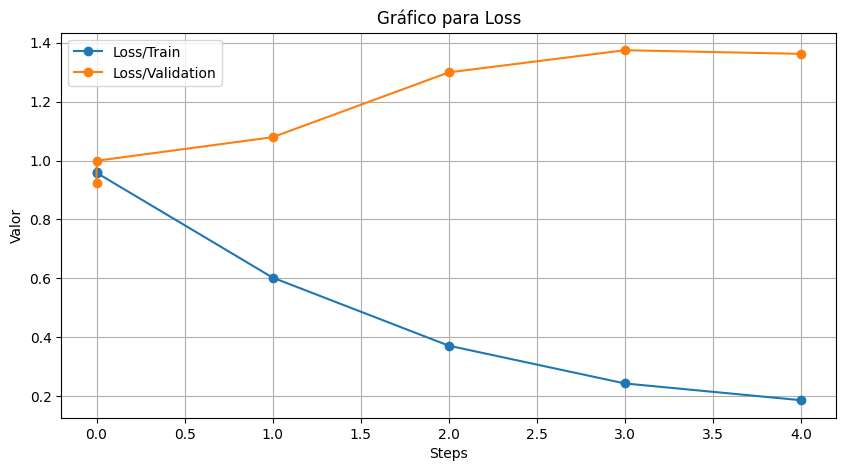

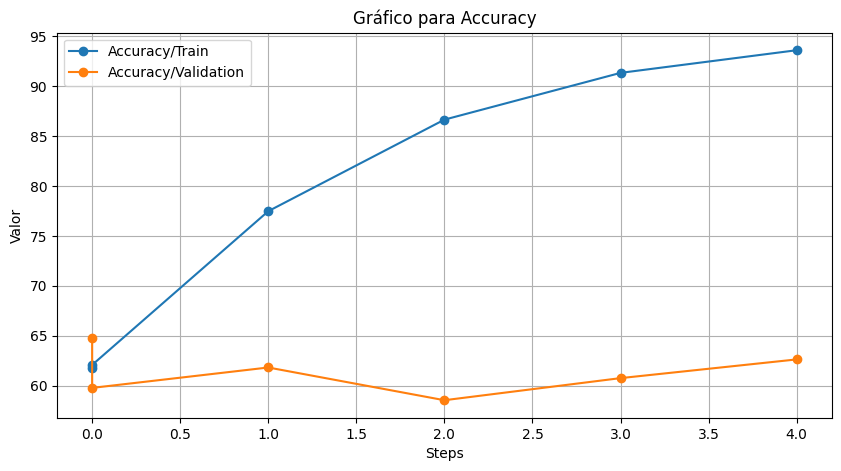

Tags de imágenes disponibles: []


In [21]:
log_dir = os.path.join(runsRoute)

ea = event_accumulator.EventAccumulator(log_dir)
ea.Reload()

scalar_tags = ea.Tags().get('scalars', [])
grouped_tags = {}
for tag in scalar_tags:
    group = tag.split('/')[0] if '/' in tag else tag
    grouped_tags.setdefault(group, []).append(tag)

for group, tags in grouped_tags.items():
    plt.figure(figsize=(10, 5))
    for tag in tags:
        events = ea.Scalars(tag)
        steps = [e.step for e in events]
        values = [e.value for e in events]
        plt.plot(steps, values, marker='o', label=tag)
    plt.title(f"Gráfico para {group}")
    plt.xlabel("Steps")
    plt.ylabel("Valor")
    plt.legend()
    plt.grid(True)
    plt.show()

# Ahora: extraer y mostrar las imágenes (los gráficos registrados como imágenes)
if 'images' in ea.Tags():
    image_tags = ea.Tags()['images']
    print("Tags de imágenes disponibles:", image_tags)
    for tag in image_tags:
        events = ea.Images(tag)
        # Puedes optar por mostrar todos los eventos o, por ejemplo, solo el último.
        for event in events:
            # Cada evento tiene el atributo 'encoded_image_string', que es el contenido de la imagen.
            image = Image.open(io.BytesIO(event.encoded_image_string))
            plt.figure(figsize=(8, 6))
            plt.imshow(image)
            plt.title(f"{tag} - Step: {event.step}")
            plt.axis("off")
            plt.show()
else:
    print("No se encontraron imágenes en los registros.")

In [22]:
# Mapeo de clases
print(class_to_idx)

{'MEL': 0, 'NV': 1, 'BCC': 2, 'BKL': 3, 'AK': 4}


## Carga de modelo

In [23]:
# Definir la arquitectura del modelo
class MiModelo(nn.Module):
    def __init__(self):
        super(MiModelo, self).__init__()
        self.fc = nn.Linear(10, 1)  # Ejemplo simple

    def forward(self, x):
        return self.fc(x)

# Instanciar el modelo
model = MiModelo()

# Carga de solo pesos
model = torch.load(os.path.join(savedParametersRoute, f"{executionModelDateTime}_modelo_entrenado_resnet18_softAtt_ka_pesos.pth"), weights_only=True, map_location=device)
# Carga del modelo
model = torch.load(os.path.join(savedModelsRoute, f"{executionModelDateTime}_modelo_entrenado_resnet18_softAtt_ka_completo.pth"), weights_only=False, map_location=device)

# Prueba del modelo

**Definición de gráficas a emplear**

In [24]:
def show_heatmap(ground_truth, predictions, class_to_idx): 
    # Generar la lista de etiquetas ordenadas según su índice
    labels = [class_name for class_name, _ in sorted(class_to_idx.items(), key=lambda x: x[1])]
    
    # Calcula la matriz de confusión usando el orden de índices
    cm = confusion_matrix(ground_truth, predictions, labels=range(len(labels)))
    
    # Crear la figura
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Groundtruth")
    ax.set_title("Matriz de Confusión por cada categoría")
    
    plt.close(fig)
    return fig

# Función para registrar la grilla 2x2 de TP, FP, TN, FN (para clasificación binaria)
def show_values_predicted(ground_truth, predictions):
    cm = confusion_matrix(ground_truth, predictions, labels=[True, False])
    cm = cm.T  

    TP = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TN = cm[1, 1]

    # Creamos la matriz personalizada en el orden: TP, FP, FN, TN
    custom_cm = np.array([[TP, FP],
                            [FN, TN]])

    # Creamos las anotaciones para cada celda
    annot = np.array([[f"TP\n{TP}", f"FP\n{FP}"],
                        [f"FN\n{FN}", f"TN\n{TN}"]])

    # Creamos la figura y el eje sin llamar a plt.show() ni plt.close(), para evitar doble impresión.
    fig, ax = plt.subplots(figsize=(6, 5))

    # Configuramos el heatmap
    sns.heatmap(custom_cm, annot=annot, fmt="", cmap="Blues",
                xticklabels=["True", "False"],   # Ground Truth
                yticklabels=["True", "False"],   # Predicciones
                cbar=True, ax=ax)

    ax.set_xlabel("Ground Truth")
    ax.set_ylabel("Predicción")
    ax.set_title("Matriz de Confusión (TP, FP, FN, TN)")

    return fig

def print_classification_report(ground_truth, predictions, class_to_idx):
    idx_to_class = {idx: label for label, idx in class_to_idx.items()}
    target_names = [idx_to_class[i] for i in sorted(idx_to_class)]
    report = classification_report(ground_truth, predictions, target_names=target_names)
    print(report)

### Prueba del modelo en el conjunto de validación

Ejecución del modelo

In [25]:
model.eval()

predictions = []
ground_truth = []
with torch.no_grad():
    for image, label in val_dataset:
        image = image.to(device)
        output = model(image.unsqueeze(0))
        probabilities = torch.nn.functional.softmax(output, dim=1)  # Usamos dim=1 porque tenemos un batch
        _, predicted_class = torch.max(probabilities, dim=1)
        predicted_class = predicted_class.item()
        predictions.append(predicted_class)
        ground_truth.append(label)

Gráficas de métricas de evaluación

Matriz de confusión por cada categoría predicha

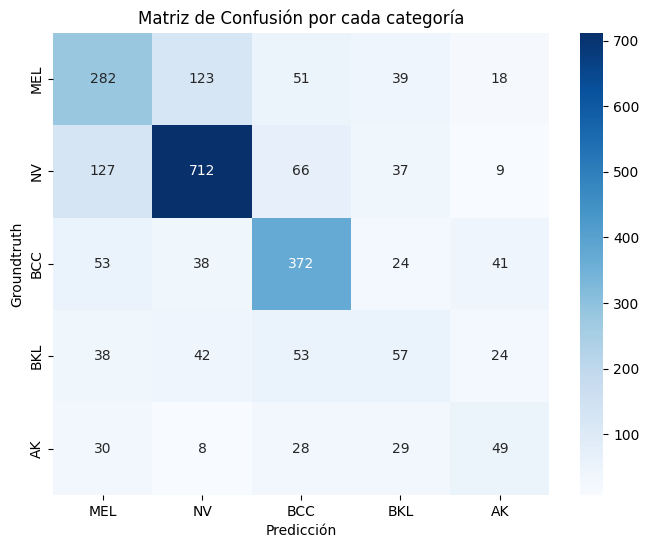

In [26]:
show_heatmap(ground_truth=ground_truth, predictions=predictions, class_to_idx=class_to_idx)

Matriz de confusion de valores totales predichos

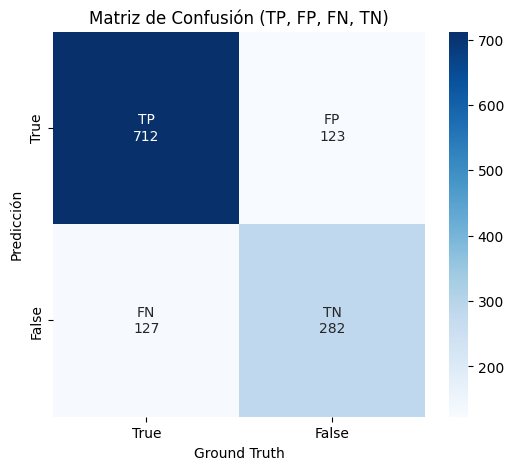

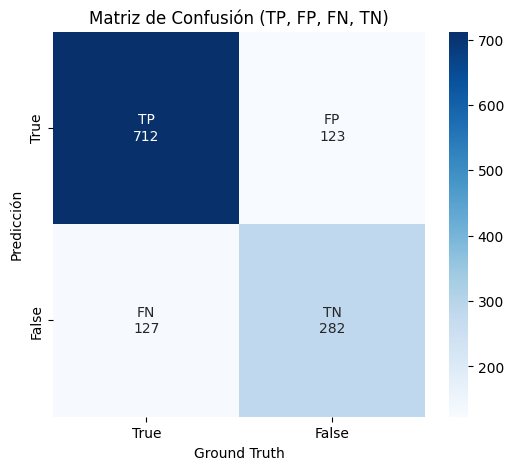

In [27]:
show_values_predicted(ground_truth=ground_truth, predictions=predictions)

Reporte de clasificación

In [28]:
print_classification_report(ground_truth, predictions, class_to_idx)

              precision    recall  f1-score   support

         MEL       0.53      0.55      0.54       513
          NV       0.77      0.75      0.76       951
         BCC       0.65      0.70      0.68       528
         BKL       0.31      0.27      0.28       214
          AK       0.35      0.34      0.34       144

    accuracy                           0.63      2350
   macro avg       0.52      0.52      0.52      2350
weighted avg       0.62      0.63      0.62      2350



In [29]:
model.eval()  # Ponemos el modelo en modo de evaluación

# Paso 3: Cargar la imagen y aplicar las transformaciones
image_path = 'ka.jpg'  # Pon aquí la ruta de tu imagen
image = Image.open(image_path)  # Abrir la imagen
image_tensor = val_transform(image)  # Aplicar las transformaciones

image_tensor = image_tensor.unsqueeze(0)  # Convertirlo a un batch de tamaño 1

# Paso 5: Mover la imagen al dispositivo (GPU o CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
image_tensor = image_tensor.to(device)
model = model.to(device)

# Paso 6: Realizar la predicción
with torch.no_grad():  # No necesitamos gradientes para la inferencia
    output = model(image_tensor)

# Paso 7: Convertir las predicciones en probabilidades con softmax
probabilities = torch.nn.functional.softmax(output, dim=1)  # Usamos dim=1 porque tenemos un batch

# Paso 8: Obtener la clase con la mayor probabilidad
_, predicted_class = torch.max(probabilities, dim=1)

# Paso 9: Interpretar la clase predicha
# Usamos el mapeo que ya tienes de clases (el 'class_to_idx' que ya definiste en tu dataset)
predicted_idx = predicted_class.item()  # Obtenemos el índice de la clase predicha
print(predicted_idx)
# Aquí usamos el mapeo de clases que creamos antes para convertir el índice a una clase legible
predicted_class_name = [key for key, value in train_dataset.class_to_idx.items() if value == predicted_idx][0]

# Mostrar la clase predicha
print(f"Predicción: {predicted_class_name}")

3
Predicción: BKL
